## High-level model of an A/D channel using a 2nd order ΣΔ modulator

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy import signal

## Parameters

In [2]:
# Modulator
Vr = 2.24               # Reference voltage     (V)
B = 20e3                # Signal bandwidth      (Hz)
OSR = 100               # Oversampling ratio 
Fs = 2*B*OSR            # Sampling frequency    (Hz)

# Decimation filter
N = int(OSR)            # Decimation factor

# Simulation parameters
np_points = 40000       # Number of points

# Input signal - sine wave 1kHz
f = 1e3
f = round((f/Fs) * np_points) * (Fs/np_points)
print(f'f={f}Hz')

# Time vector
t = np.arange(np_points) / Fs

f=1000.0Hz


## Modulator

In [3]:
# Define coefficients
k1 = 1
k2 = 1
b1 = 1
b2 = 2
B1 = 1
B2 = 1

In [4]:
# Function to implement the Modulator
@nb.jit(nopython=True)
def second_order_sigma_delta_modulator(vin):

    npoints = len(vin)
    dout = np.zeros(npoints)
    e1 = np.zeros(npoints)  # First integrator error
    e2 = np.zeros(npoints)  # Second integrator error
    x1 = np.zeros(npoints)  # First integrator state
    x2 = np.zeros(npoints)  # Second integrator state

    # Modulator loop
    for n in range(1, npoints):

        # Quantizer
        if x2[n-1] >= 0:
            dout[n] = 1
        else:
            dout[n] = -1

        # First integrator
        e1[n] = vin[n] - dout[n] * (Vr*b1)
        x1[n] = k1 * e1[n] + B1 * x1[n-1]
        
        # Second integrator
        e2[n] = x1[n-1] - dout[n] * (Vr*b2)
        x2[n] = k2 * e2[n] + B2 * x2[n-1]
    
    return dout

## Functions

## (d)
### Obtain dout for a sinewave input signal with frequency of 1kHz 

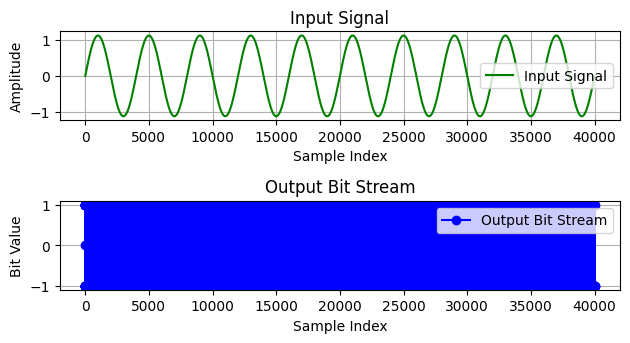

In [5]:
# Simple input signal
Ain = Vr/2
Vnoise = 2e-12

# Create input signal
vin = Ain * np.sin(2 * np.pi * f * t) + np.random.randn(np_points) * Vnoise

# Modulator
dout = second_order_sigma_delta_modulator(vin)

# Input signal subplot
plt.subplot(3, 1, 1)
plt.plot(vin, label='Input Signal', color='green')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Input Signal')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Output bit stream subplot
plt.subplot(3, 1, 2)
plt.plot(dout, label='Output Bit Stream', color='blue', marker='o', linestyle='-')
plt.xlabel('Sample Index')
plt.ylabel('Bit Value')
plt.title('Output Bit Stream')
plt.grid(True)
plt.legend()
plt.tight_layout()

## e)
### Obtain the spectrum of dout and calculate the SNDR for different values of thermal noise

Simulating Noise level: 1uV...
Ps= 0.032244734468206096 PN= 3.4447601715559273e-10 SNDR=79.71 dB
 Ps= -9.04 dB
Simulating Noise level: 10uV...
Ps= 0.03224473367403362 PN= 2.424985073856689e-10 SNDR=81.24 dB
 Ps= -9.04 dB
Simulating Noise level: 100uV...
Ps= 0.03224462855058893 PN= 3.0998428129924704e-10 SNDR=80.17 dB
 Ps= -9.04 dB
Simulating Noise level: 1000uV...
Ps= 0.03224677691786837 PN= 8.285610947345035e-10 SNDR=75.90 dB
 Ps= -9.04 dB


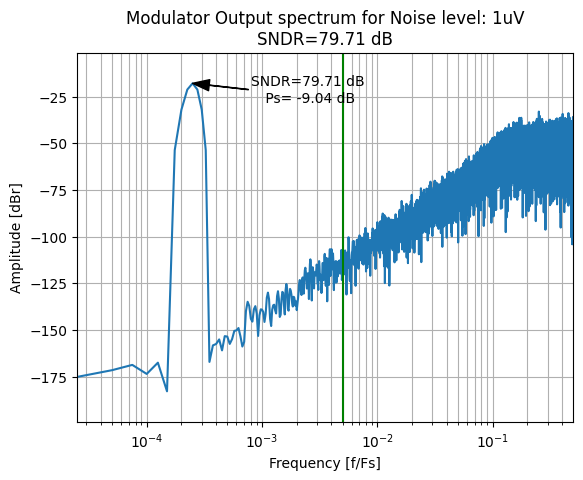

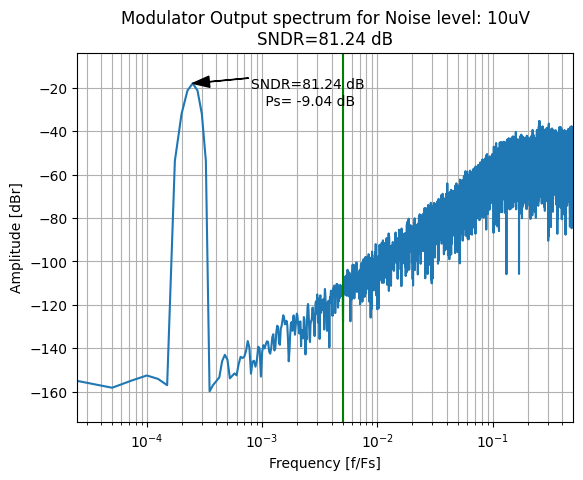

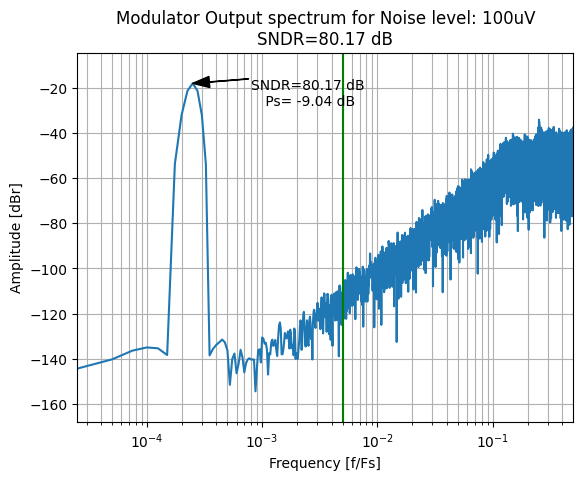

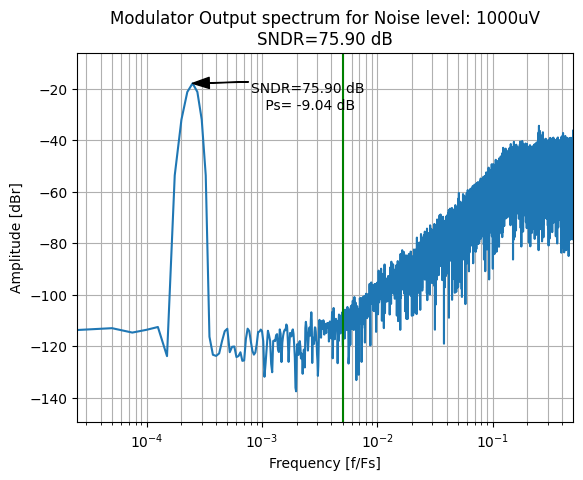

In [6]:
# Input signal with different values for Vnoise
Ain = Vr/2
noise_levels = [1e-6, 1e-5, 1e-4, 1e-3]  # Different noise levels [1uV, 10uV, 100uV, 1000uV]

for Vnoise in noise_levels:
    print(f'Simulating Noise level: {Vnoise*1e6:.0f}uV...')

    # Create input signal
    vin = Ain * np.sin(2 * np.pi * f * t) + np.random.randn(np_points) * Vnoise
    

    # Modulator
    dout = second_order_sigma_delta_modulator(vin)

    fin = f         # input signal frequency stays the same
    fs = Fs         # fs stays the same
    osr = OSR       # osr stays the same

    # Calculate SNDR at the output of modulator
    Nfft = len(dout)
    window = signal.windows.blackmanharris(Nfft)    # blackmanharris window
    doutw = np.fft.fft(np.multiply(dout, window))
    doutp = np.abs(np.multiply(doutw,doutw.conjugate())/((Nfft)**2)*2)

    index = int((Nfft * fin) / fs)
    Ps_nofilter = np.abs(np.sum(doutp[index - 4: index + 4]))  # blackmanharris offset = 4
    Pn_nofilter = np.abs(np.sum(doutp[:round(Nfft / (2 * osr))])) - Ps_nofilter
    SNDR_nofilter = 10 * np.log10(Ps_nofilter / Pn_nofilter)

    # Output spectrum for non-filtered output
    
    text_SNDR=f'SNDR={SNDR_nofilter:.2f}'+f' dB\n Ps= {10*np.log10(abs(Ps_nofilter))+5.88:.2f} dB'
    print('Ps=',Ps_nofilter,'PN=',Pn_nofilter,text_SNDR)
    Nfft = len(dout)
    freq = np.linspace(0, 1, Nfft)
    plt.figure()
    plt.semilogx(freq[0:int(Nfft/2)],10*np.log10(abs(doutp[0:int(Nfft/2)])))
    plt.title(f'Modulator Output spectrum for Noise level: {Vnoise*1e6:.0f}uV\nSNDR={SNDR_nofilter:.2f} dB')
    plt.xlabel('Frequency [f/Fs]')
    plt.ylabel('Amplitude [dBr]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(1/(2*osr), color='green') # Bandwidth
    plt.annotate(text_SNDR,
             xy = (fin/fs, 10*np.log10(abs(doutp[int(fin*Nfft/fs)]))),
             xytext = (fin/fs*10, 10*np.log10(abs(doutp[int(fin*Nfft/fs)]))-10),
             arrowprops = dict(facecolor = 'black', width = 0.2, headwidth = 8),
             horizontalalignment = 'center')

    

## f)
### SINAD - Obtain the SNDR values for different input amplitudes

Simulating Noise level: 1uV...
Simulating Noise level: 10uV...
Simulating Noise level: 100uV...
Simulating Noise level: 1000uV...


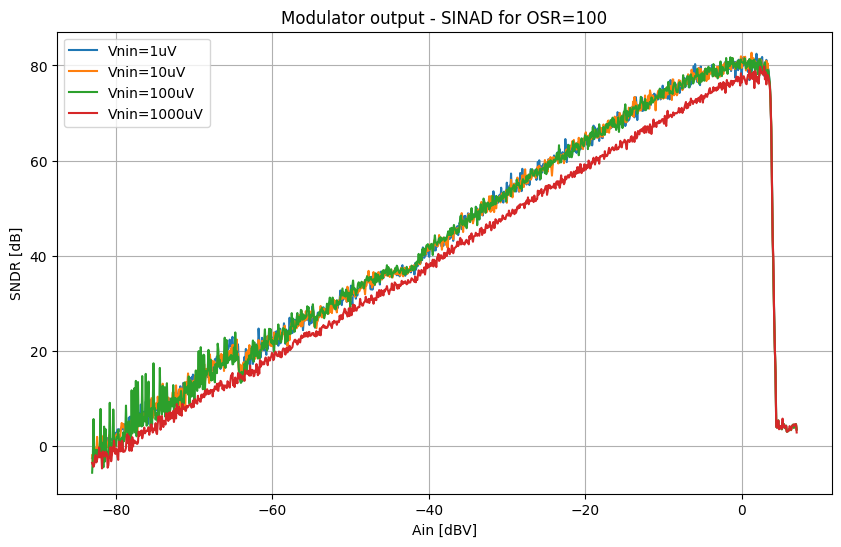

In [7]:
Ain_values = np.logspace(np.log10(1e-4), np.log10(Vr*np.sqrt(2)), 1000)         # Multiple input amplitudes
noise_levels = [1e-6, 1e-5, 1e-4, 1e-3]                                         # Multiple noise levels
#noise_levels = [1e-5]                                                          # Single (adequate) noise level

SNDR_values = {Vnoise: [] for Vnoise in noise_levels}                   # Storage for SNDR values

for Vnoise in noise_levels:
    print(f'Simulating Noise level: {Vnoise*1e6:.0f}uV...')
    for Ain in Ain_values:
        
        # Create input signal
        vin = Ain * np.sin(2 * np.pi * f * t) + np.random.randn(np_points) * Vnoise

        # Modulator
        dout = second_order_sigma_delta_modulator(vin)
        # No filter
        fin = f         # input signal frequency stays the same
        fs = Fs         # fs stays the same
        osr = OSR       # osr stays the same
        
        # Calculate SNDR at the output of modulator
        Nfft = len(dout)
        window = signal.windows.blackmanharris(Nfft)    # blackmanharris window
        doutw = np.fft.fft(np.multiply(dout, window))
        doutp = np.abs(np.multiply(doutw,doutw.conjugate())/((Nfft)**2)*2)

        index = int((Nfft * fin) / fs)
        Ps_nofilter = np.abs(np.sum(doutp[index - 4: index + 4]))  # Blackman-Harris offset = 4
        Pn_nofilter = np.abs(np.sum(doutp[:round(Nfft / (2 * osr))])) - Ps_nofilter
        SNDR_nofilter = 10 * np.log10(Ps_nofilter / Pn_nofilter)

        SNDR_values[Vnoise].append(SNDR_nofilter)


# Plot the SINAD results
plt.figure(figsize=(10, 6))
for noise in noise_levels:
    plt.plot(20 * np.log10(Ain_values / np.sqrt(2)), SNDR_values[noise], label=f'Vnin={noise*1e6:.0f}uV')

if len(noise_levels) == 1:
    # Find the max SNDR and corresponding amplitude
    max_sndr_nofilter = np.max(SNDR_values[noise])
    max_sndr_index_nofilter = np.argmax(SNDR_values[noise])

    # Find the index of the max SNDR value - 3 dB
    target_sndr = max_sndr_nofilter - 3
    max_minus_3db_index = np.argmin(np.abs(SNDR_values[noise][:max_sndr_index_nofilter] - target_sndr))
    max_minus_3db_amplitude_nofilter = Ain_values[max_minus_3db_index]

    # Find the amplitude corresponding to SNDR = 0 dB, only considering values to the left of the max SNDR
    snr_threshold = 0  # SNDR = 0 dB
    snr_diff_left = np.abs(np.array(SNDR_values[noise][:max_minus_3db_index]) - snr_threshold)
    zero_sndr_index_nofilter = np.argmin(snr_diff_left)
    zero_sndr_amplitude_nofilter = Ain_values[zero_sndr_index_nofilter]
 
    # Find the amplitude corresponding to the max SNDR-3dB and zero SNDR in dBV
    max_minus_3db_amplitude_dBV = 20 * np.log10(max_minus_3db_amplitude_nofilter / np.sqrt(2))
    zero_sndr_amplitude_dBV = 20 * np.log10(zero_sndr_amplitude_nofilter / np.sqrt(2))

    # Calculate dynamic range
    dynamic_range = max_minus_3db_amplitude_dBV - zero_sndr_amplitude_dBV

    plt.axvline(x=max_minus_3db_amplitude_dBV, color='k', linestyle='--', label=f'Max SNDR-3dB at {max_minus_3db_amplitude_dBV:.2f} dBV')
    plt.axhline(y=target_sndr, color='k', linestyle='--')
    plt.axvline(x=zero_sndr_amplitude_dBV, color='k', linestyle='--', label=f'SNDR=0dB at {zero_sndr_amplitude_dBV:.2f} dBV')

    # Add bidirectional arrow
    plt.annotate('', xy=(zero_sndr_amplitude_dBV, max_sndr_nofilter), xytext=(max_minus_3db_amplitude_dBV, max_sndr_nofilter),
                    arrowprops=dict(arrowstyle='<->', color='red'))
    plt.text((zero_sndr_amplitude_dBV + max_minus_3db_amplitude_dBV) / 2, max_sndr_nofilter + +1,
                f'Dynamic Range: {dynamic_range:.2f} dBV', ha='center', color='red')

    plt.title(f'Modulator output - SINAD for OSR={OSR} and Max SNDR: {max_sndr_nofilter:.2f} dB')

else:
    plt.title(f'Modulator output - SINAD for OSR={OSR}')

plt.xlabel('Ain [dBV]')
plt.ylabel('SNDR [dB]')
plt.grid(True)
plt.legend()


## g)
### Repeat the previous question considering finite gain in the amplifiers

In [62]:
# Integrator amplifiers with finite gain
A = 100 # 40dB
B1 = (A + 1) / (A + 2 + b1)
B2 = (A + 1) / (A + 2 + b2)

# Function to implement the Modulator
@nb.jit(nopython=True)
def second_order_sigma_delta_modulator(vin):

    npoints = len(vin)
    dout = np.zeros(npoints)
    e1 = np.zeros(npoints)  # First integrator error
    e2 = np.zeros(npoints)  # Second integrator error
    x1 = np.zeros(npoints)  # First integrator state
    x2 = np.zeros(npoints)  # Second integrator state

    # Init
    x1[0]=1e-12
    x2[0]=1e-12

    # Modulator loop
    for n in range(1, npoints):

        # Quantizer
        if x2[n-1] >= 0:
            dout[n] = 1
        else:
            dout[n] = -1

        # First integrator
        e1[n] = vin[n] - dout[n] * (Vr*b1)
        x1[n] = k1 * e1[n] + B1 * x1[n-1]
        
        # Second integrator
        e2[n] = x1[n-1] - dout[n] * (Vr*b2)
        x2[n] = k2 * e2[n] + B2 * x2[n-1]
    
    return dout

Simulating Noise level: 1uV...
Simulating Noise level: 10uV...
Simulating Noise level: 100uV...
Simulating Noise level: 1000uV...


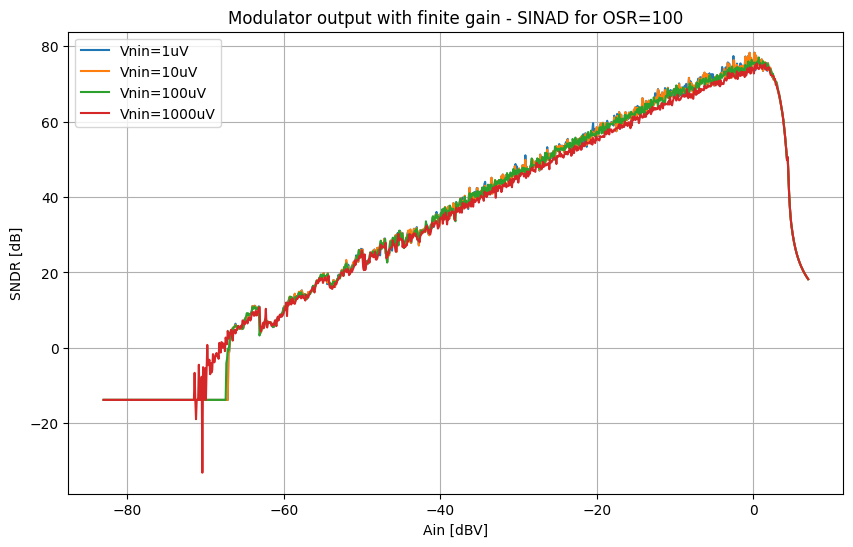

In [63]:

Ain_values = np.logspace(np.log10(1e-4), np.log10(Vr*np.sqrt(2)), 1000)         # Multiple input amplitudes
noise_levels = [1e-6, 1e-5, 1e-4, 1e-3]                                         # Multiple noise levels
#noise_levels = [1e-5]                                                          # Single (adequate) noise level

SNDR_values = {Vnoise: [] for Vnoise in noise_levels}                   # Storage for SNDR values

for Vnoise in noise_levels:
    print(f'Simulating Noise level: {Vnoise*1e6:.0f}uV...')
    for Ain in Ain_values:
        
        # Create input signal
        vin = Ain * np.sin(2 * np.pi * f * t) + np.random.randn(np_points) * Vnoise
        
        # Modulator
        dout = second_order_sigma_delta_modulator(vin)

        # No filter
        fin = f         # input signal frequency stays the same
        fs = Fs         # fs stays the same
        osr = OSR       # osr stays the same

        # Calculate SNDR at the output of modulator
        Nfft = len(dout)
        window = signal.windows.blackmanharris(Nfft)    # blackmanharris window
        doutw = np.fft.fft(np.multiply(dout, window))
        doutp = np.abs(np.multiply(doutw,doutw.conjugate())/((Nfft)**2)*2)

        index = int((Nfft * fin) / fs)
        Ps_nofilter = np.abs(np.sum(doutp[index - 4: index + 4]))  # blackmanharris offset = 4
        Pn_nofilter = np.abs(np.sum(doutp[:round(Nfft / (2 * osr))])) - Ps_nofilter
        SNDR_nofilter = 10 * np.log10(Ps_nofilter / Pn_nofilter)

        SNDR_values[Vnoise].append(SNDR_nofilter)


# Plot the SINAD results
plt.figure(figsize=(10, 6))
for noise in noise_levels:
    plt.plot(20 * np.log10(Ain_values / np.sqrt(2)), SNDR_values[noise], label=f'Vnin={noise*1e6:.0f}uV')

    if len(noise_levels) == 1:
        # Find the max SNDR and corresponding amplitude
        max_sndr_nofilter = np.max(SNDR_values[noise])
        max_sndr_index_nofilter = np.argmax(SNDR_values[noise])
        max_sndr_amplitude_nofilter = Ain_values[max_sndr_index_nofilter]

        # Find the amplitude corresponding to SNDR = 0 dB, only considering values to the left of the max SNDR
        snr_threshold = 0  # SNDR = 0 dB
        snr_diff_left = np.abs(np.array(SNDR_values[noise][:max_sndr_index_nofilter]) - snr_threshold)
        zero_sndr_index_nofilter = np.argmin(snr_diff_left)
        zero_sndr_amplitude_nofilter = Ain_values[zero_sndr_index_nofilter]

        # Find the amplitude corresponding to the maximum SNDR and zero SNDR in dBV
        max_sndr_amplitude_dBV = 20 * np.log10(max_sndr_amplitude_nofilter / np.sqrt(2))
        zero_sndr_amplitude_dBV = 20 * np.log10(zero_sndr_amplitude_nofilter / np.sqrt(2))

        # Calculate dynamic range
        dynamic_range = max_sndr_amplitude_dBV - zero_sndr_amplitude_dBV


        plt.axvline(x=max_sndr_amplitude_dBV, color='r', linestyle='--', label=f'Max SNDR at {max_sndr_amplitude_dBV:.2f} dBV')
        plt.axhline(y=max_sndr_nofilter, color='r', linestyle='--')
        plt.axvline(x=zero_sndr_amplitude_dBV, color='b', linestyle='--', label=f'SNDR=0dB at {zero_sndr_amplitude_dBV:.2f} dBV')

        plt.title(f'Modulator output with finite gain - SINAD for OSR={OSR}\nMax SNDR: {max_sndr_nofilter:.2f} dB with Ain: {max_sndr_amplitude_nofilter:.2f} V\nDynamic Range: {dynamic_range:.2f} dB')

    else:
        plt.title(f'Modulator output with finite gain - SINAD for OSR={OSR}')

plt.xlabel('Ain [dBV]')
plt.ylabel('SNDR [dB]')
plt.grid(True)
plt.legend()

## Decimation Filter Implementation as a 3rd order Sinc filter

In [8]:
len_dec = (np_points // N) + 1

# Initialize integrator variables
int1 = np.zeros(np_points)
int2 = np.zeros(np_points)
int3 = np.zeros(np_points)

# Initialize differentiator variables
diff1 = np.zeros(len_dec)
diff2 = np.zeros(len_dec)
diff3 = np.zeros(len_dec)

# Function to implement the third-order sinc filter
def third_order_sinc_filter(dout, N):
    # Initialize integrator variables
    int1 = np.cumsum(dout)
    int2 = np.cumsum(int1)
    int3 = np.cumsum(int2)

    # Decimation
    decim = int3[::N]

    # Differentiation
    diff1 = np.diff(np.concatenate(([0], decim)))
    diff2 = np.diff(np.concatenate(([0], diff1)))
    diff3 = np.diff(np.concatenate(([0], diff2)))

    # Gain correction
    filtered_signal = diff3 / (N ** 3)

    return filtered_signal

## h) and k)
### Obtain the SNDR at the filter output

Ps= 0.0514095453821514 PN= 8.056406583523135e-10 SNDR=78.05 dB
 Ps= -7.01 dB
Ps= 0.03224476116861384 PN= 7.093991574724789e-10 SNDR=76.58 dB
 Ps= -9.04 dB
Ps= 0.0005111480713293878 PN= 5.753233960200874e-10 SNDR=59.49 dB
 Ps= -27.03 dB
Ps= 5.12013648821744e-06 PN= 8.941997919623476e-10 SNDR=37.58 dB
 Ps= -47.03 dB


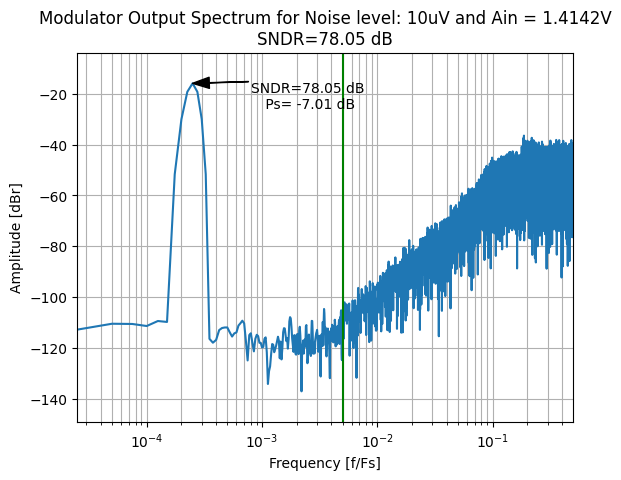

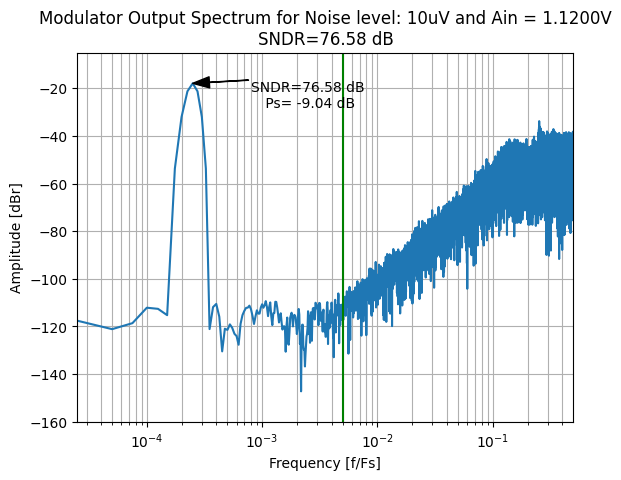

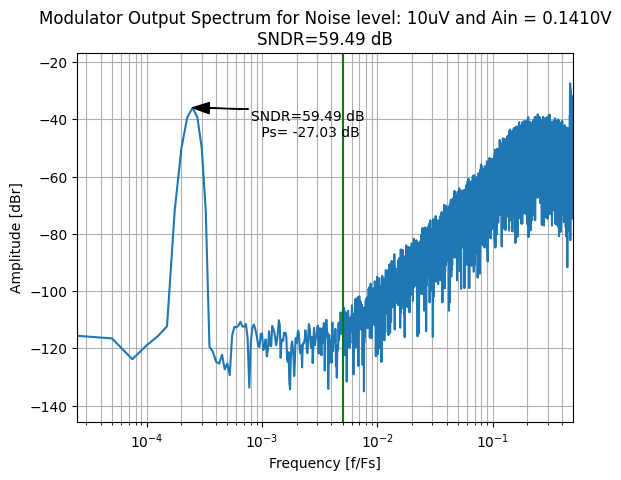

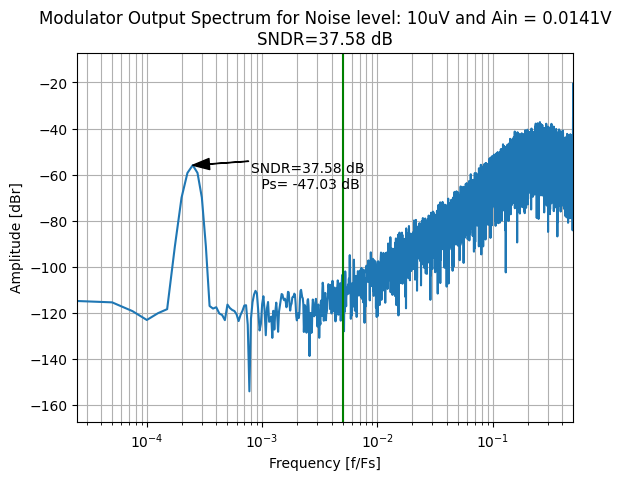

In [11]:
# Simple input signal
#Ain_values = [Vr/2]
Ain_values = [1.4142, Vr/2, 0.141, 0.0141]  #[1Vrms, Vr/2, -20dBv, -40dBv]
Vnoise = 1e-5

for Ain in Ain_values:
    # Create input signal
    vin = Ain * np.sin(2 * np.pi * f * t) + np.random.randn(np_points) * noise

    # Modulator
    dout = second_order_sigma_delta_modulator(vin)

    # Filtered output
    doutf = third_order_sinc_filter(dout, N)

    # No filter
    fin = f         # input signal frequency stays the same
    fs = Fs         # fs stays the same
    osr = OSR       # osr stays the same

    # Calculate SNDR at the output of modulator
    Nfft = len(dout)
    window = signal.windows.blackmanharris(Nfft)    # blackmanharris window
    doutw = np.fft.fft(np.multiply(dout, window))
    doutp = np.abs(np.multiply(doutw,doutw.conjugate())/((Nfft)**2)*2)

    index = int((Nfft * fin) / fs)
    Ps_nofilter = np.abs(np.sum(doutp[index - 4: index + 4]))  # blackmanharris offset = 4
    Pn_nofilter = np.abs(np.sum(doutp[:round(Nfft / (2 * osr))])) - Ps_nofilter
    SNDR_nofilter = 10 * np.log10(Ps_nofilter / Pn_nofilter)

    SNDR_values[Vnoise].append(SNDR_nofilter)


    # Output spectrum for filtered output

    text_SNDR=f'SNDR={SNDR_nofilter:.2f}'+f' dB\n Ps= {10*np.log10(abs(Ps_nofilter))+5.88:.2f} dB'
    print('Ps=',Ps_nofilter,'PN=',Pn_nofilter,text_SNDR)
    Nfft = len(dout)
    freq = np.linspace(0, 1, Nfft)
    plt.figure()
    plt.semilogx(freq[0:int(Nfft/2)],10*np.log10(abs(doutp[0:int(Nfft/2)])))
    plt.title(f'Modulator Output Spectrum for Noise level: {Vnoise*1e6:.0f}uV and Ain = {Ain:.4f}V\nSNDR={SNDR_nofilter:.2f} dB')
    plt.xlabel('Frequency [f/Fs]')
    plt.ylabel('Amplitude [dBr]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(1/(2*osr), color='green') # Bandwidth
    plt.annotate(text_SNDR,
                xy = (fin/fs, 10*np.log10(abs(doutp[int(fin*Nfft/fs)]))),
                xytext = (fin/fs*10, 10*np.log10(abs(doutp[int(fin*Nfft/fs)]))-10),
                arrowprops = dict(facecolor = 'black', width = 0.2, headwidth = 8),
                horizontalalignment = 'center')